In [474]:
#Adapted from the Keras Example https://keras.io/examples/structured_data/collaborative_filtering_movielens/

# Assessed Assignment 2

Please remember to comment your code clearly, submit ``.ipynb`` 

## Task 1

We're going to ask you take the trained model and write the code to make two metrics - **Diversity** and **Novelty**. You should end up with **one statistic** for each that tells you something about the recommendations of the trained model based on the **whole dataset**.


#### Pro Tip

This will take quite a long time to run on the whole dataset, so start off by trying to get the code to work for **one user**, then expand to **two users**, then **every user**.

### Diversity 

This tells us what the mean diversity (inverse of the similarity, based on movie embeddings) between each film in every users Top 10 films is. 

1. Calculate every user's top 10


2. For each top 10, get the embedding for each film then use this to calculate the similarity matrix


3. Invert similarity to get the difference


4. Get mean difference for each top 10 


5. Report the mean for whole dataset (every top 10)


### Novelty 

This tells us what the mean popularity (e.g. mean rating) of the films in every users Top 10 films is 

1. Calculate every user's top 10


2. For each top 10, get the mean rating for each film (based on the original **MovieLens Small** dataset (``df = pd.read_csv("ml-latest-small/ratings.csv")``). 


3. Get the mean rating for each top 10.


4. Report the mean for the whole dataset (every top 10).



## Task 2

Using a dimensionality reduction approach (PCA? TSNE?), plot the top 30 best rated films on a 2-D graph based on their movie embeddings. Label each point with the title.

There is infact ~400 films that have an average rating of 5 (because some films have only 1 rating). Can you adjust or filter for this?

# Assignment Task 1 

### Loading dataset and Prepare Data and Model for Training

In [2]:
## IMPORT modular ##
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import torch

In [3]:
df = pd.read_csv("/home/featurize/ratings.csv")
len(df)

100004

In [4]:
df.tail(200)

,userId,movieId,rating,timestamp
99804,668,608,5.0,993613478
99805,668,720,3.0,993613415
99806,668,1089,3.0,993613415
99807,668,1213,5.0,993613359
99808,668,1221,5.0,993613196
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


In [5]:
#Use the unique() function to get the total number of unique users and movies 
#(essentially removing duplicates)
user_ids = df["userId"].unique().tolist()   #Puts unique user IDs into a list
movie_ids = df["movieId"].unique().tolist()  #Puts unique movie IDs into a list

In [15]:
print('There are have', len(movie_ids), 'movies in this dataset and', len(user_ids), 'users')

There are have 9066 movies in this dataset and 671 users


In [7]:
#Make a dictionary mapping ids (keys, x) to indexes (values, i)
user_id_to_index = {x: i for i, x in enumerate(user_ids)}
movie_id_to_index = {x: i for i, x in enumerate(movie_ids)}

In [8]:
#Make a new column in the dataframe which contains the appropriate index for each user and movie
df["user_index"] = [user_id_to_index[i] for i in df["userId"]]
df["movie_index"] = [movie_id_to_index[i] for i in df["movieId"]]

In [9]:
df.head(10)

,userId,movieId,rating,timestamp,user_index,movie_index
0,1,31,2.5,1260759144,0,0
1,1,1029,3.0,1260759179,0,1
2,1,1061,3.0,1260759182,0,2
3,1,1129,2.0,1260759185,0,3
4,1,1172,4.0,1260759205,0,4
5,1,1263,2.0,1260759151,0,5
6,1,1287,2.0,1260759187,0,6
7,1,1293,2.0,1260759148,0,7
8,1,1339,3.5,1260759125,0,8
9,1,1343,2.0,1260759131,0,9


In [14]:
#Scale ratings data to be in the range [0,1]
#This makes things easier
from sklearn.preprocessing import MinMaxScaler
##Pick the range\
df["rating"] = MinMaxScaler().fit_transform(df["rating"].values.reshape(-1, 1))
df["rating"].describe()

count    100004.000000
mean          0.676357
std           0.235125
min           0.000000
25%           0.555556
50%           0.777778
75%           0.777778
max           1.000000
Name: rating, dtype: float64

In [12]:
#Check the dataframe
df.head(10)

,userId,movieId,rating,timestamp,user_index,movie_index
0,1,31,0.444444,1260759144,0,0
1,1,1029,0.555556,1260759179,0,1
2,1,1061,0.555556,1260759182,0,2
3,1,1129,0.333333,1260759185,0,3
4,1,1172,0.777778,1260759205,0,4
5,1,1263,0.333333,1260759151,0,5
6,1,1287,0.333333,1260759187,0,6
7,1,1293,0.333333,1260759148,0,7
8,1,1339,0.666667,1260759125,0,8
9,1,1343,0.333333,1260759131,0,9


In [17]:
from sklearn.model_selection import train_test_split

In [18]:
x = df[["user_index", "movie_index"]] #Inputs
y = df["rating"] #Outputs
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42) #Get train-test split

In [19]:
## DEFINE THE MODEL ##

class RecommenderNet(torch.nn.Module):
    def __init__(self, num_users, num_movies, embedding_size=20):
        super().__init__()
        self.user_embedding = torch.nn.Embedding(num_users, embedding_size)
        self.user_bias = torch.nn.Embedding(num_users, 1)
        self.movie_embedding = torch.nn.Embedding(num_movies, embedding_size)
        self.movie_bias = torch.nn.Embedding(num_movies, 1)
        self.sig = torch.nn.Sigmoid()

    def forward(self, inputs):
        #Split out indexes 
        user_indexes = inputs[:, 0]
        movie_indexes = inputs[:, 1]
        #Forward pass on embedding layer
        user_vector = self.user_embedding(user_indexes)
        user_bias = self.user_bias(user_indexes).flatten()
        movie_vector = self.movie_embedding(movie_indexes)
        movie_bias = self.movie_bias(movie_indexes).flatten()
        #Dot product
        dot = (user_vector * movie_vector).sum(1)
        with_bias = dot + user_bias + movie_bias
        #Activation function
        output = self.sig(with_bias)
        return output

In [22]:
## SET UP THE MODEL ##
EMBEDDING_SIZE = 16 #Pick Embedding size
#Make new object (calls __init__())
num_users = len(user_ids)
num_movies = len(movie_ids)
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)

In [23]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

#Make a subclass to hold our dataset (movie - user pairs (input) and a rating (label))
class MoviesDataset(Dataset):
    def __init__(self, X,y):
        self.X = torch.IntTensor(X)
        self.y = torch.FloatTensor(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

Use the train - valid split to make dataloader objects

In [24]:
train_dl = DataLoader(MoviesDataset(x_train.values,y_train.values), batch_size=64, shuffle=True)
validation_dl = DataLoader(MoviesDataset(x_test.values,y_test.values), batch_size=64, shuffle=True)

In [26]:
epochs = 40
#Use Mean Squared Error as a loss function
loss_fn = torch.nn.MSELoss() 
#Use the Adam algorithm to update the weights based on the loss
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

In [27]:
#Use a for loop to repeat for the desired number of epochs 
for i in range(epochs):
    
    model.train(True)
    
    #Use a for loop for each batch (provided by the Dataloader)
    running_loss = 0.0
    for (index, batch) in enumerate(train_dl):
        
        #Get batch 
        inputs, labels = batch
        model.zero_grad()
        
        #Forward pass
        prediction = model(inputs)
        
        #Get Loss
        loss = loss_fn(prediction, labels)
        
        #Update weights (back prop)
        loss.backward()
        optimizer.step()
        running_loss += loss
    
    avg_loss = running_loss / (index + 1)

    model.train(False)

    #Now try with the validation set (no need to update weights, just get loss)
    running_vloss = 0.0
    for index, vdata in enumerate(validation_dl):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (index + 1)
    print('Loss {} valid Loss {}'.format(avg_loss, avg_vloss))

Loss 0.17188860476016998 valid Loss 0.11426646262407303
Loss 0.07757384330034256 valid Loss 0.08189493417739868
Loss 0.04925111308693886 valid Loss 0.07100947946310043
Loss 0.03734023496508598 valid Loss 0.06702039390802383
Loss 0.031242750585079193 valid Loss 0.06351478397846222
Loss 0.02767421118915081 valid Loss 0.06326999515295029
Loss 0.02518506534397602 valid Loss 0.06302674859762192
Loss 0.02372647263109684 valid Loss 0.06433404982089996
Loss 0.02252057008445263 valid Loss 0.06452123820781708
Loss 0.021574944257736206 valid Loss 0.06377163529396057
Loss 0.021158527582883835 valid Loss 0.06417026370763779
Loss 0.020553337410092354 valid Loss 0.06386887282133102
Loss 0.02017665095627308 valid Loss 0.0645112469792366
Loss 0.019846133887767792 valid Loss 0.06427892297506332
Loss 0.019456781446933746 valid Loss 0.06569875776767731
Loss 0.019278040155768394 valid Loss 0.06430889666080475
Loss 0.01910562813282013 valid Loss 0.0654091089963913
Loss 0.018828995525836945 valid Loss 0.0650

In [28]:
torch.save(model.state_dict(), 'moive_rating_model_weights.pth')

In [30]:
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.load_state_dict(torch.load('/home/featurize/moive_rating_model_weights.pth'))
model.eval()

RecommenderNet(
  (user_embedding): Embedding(671, 16)
  (user_bias): Embedding(671, 1)
  (movie_embedding): Embedding(9066, 16)
  (movie_bias): Embedding(9066, 1)
  (sig): Sigmoid()
)

## Training the model

In [40]:
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity as cosine
from sklearn.preprocessing import StandardScaler

In [41]:
# get columns
movie_data = pd.read_csv("/home/featurize/movies.csv")
movie_data.columns

Index(['movieId', 'title', 'genres'], dtype='object')

In [91]:
def get_top_n(user = 0, n = 10): 
    #Get Movie Names
    top_n_indexes = get_top_n_indexes(user, n)
    top_n = get_names_for_indexes(top_n_indexes)
    return top_n

def get_n_for_indexes(indexes):
    return [movie_data[movie_data["movieId"]==movie_ids[i]]["title"].item() for i in indexes]

def get_top_n_indexes(user = 0, n = 10):
    #For one user, make a pair with every movie index
    x = torch.IntTensor([[user, i] for i in np.arange(num_movies)])
    #Predict 
    predicted_ratings = model(x)
    #Get Top-N indexes
    top_n_indexes = predicted_ratings.argsort()[-n:]
    return top_n_indexes

## Calculate every user's top 10

In [92]:
#Random users top 10
user = np.random.randint(num_users)
print("Top 10 for user id:", user_ids[user])
get_top_name(np.random.randint(num_users))

Top 10 for user id: 151


['Kwaidan (Kaidan) (1964)',
 'An Evening with Robin Williams (1982)',
 'Seducing Doctor Lewis (Grande séduction, La) (2003)',
 'Jesus of Montreal (Jésus de Montréal) (1989)',
 'Maborosi (Maboroshi no hikari) (1995)',
 'On Probation (Tiempo de Valientes) (2005)',
 'Bill Hicks: Revelations (1993)',
 'Green for Danger (1946)',
 'Rivers and Tides (2001)',
 'Thief of Bagdad, The (1924)']

## top 10 recommendations for each user

In [94]:
top10_movies_per_user = []  # Create an empty list to store top 10 recommendations for each user

# Iterate over each user
for user in range(num_users):
    # Get the top 10 movie recommendations for the current user
    top10_movies = get_top_n(user, n=10)
    top10_movies_per_user.append(top10_movies)  # Append the top 10 movies to the list

In [95]:
print(df.head())

   userId  movieId    rating   timestamp  user_index  movie_index
0       1       31  0.444444  1260759144           0            0
1       1     1029  0.555556  1260759179           0            1
2       1     1061  0.555556  1260759182           0            2
3       1     1129  0.333333  1260759185           0            3
4       1     1172  0.777778  1260759205           0            4


In [96]:
for user_movies in top10_movies_per_user[:2]:
    print(user_movies)

['Maborosi (Maboroshi no hikari) (1995)', 'Cops (1922)', 'Kwaidan (Kaidan) (1964)', 'Dorian Blues (2004)', 'Birdy (1984)', 'Dark Days (2000)', 'Thirty-Two Short Films About Glenn Gould (1993)', 'Phantom of the Paradise (1974)', "Sgt. Pepper's Lonely Hearts Club Band (1978)", 'Past, The (Le passé) (2013)']
['Shining Through (1992)', 'Offside (2006)', '16 Wishes (2010)', 'Maborosi (Maboroshi no hikari) (1995)', 'North Shore (1987)', 'Bill Hicks: Relentless (1992)', 'Bill Hicks: Revelations (1993)', 'Red Firecracker, Green Firecracker (Pao Da Shuang Deng) (1994)', 'Arthur 2: On the Rocks (1988)', "Love Me If You Dare (Jeux d'enfants) (2003)"]


## top_recommendation_user1

Print the top recommendation for the first user

In [102]:
top_recommendation_user1 = top10_movies_per_user[0][9]
print("Top Recommendation for User 1:", top_recommendation_user1)

Top Recommendation for User 1: Past, The (Le passé) (2013)


## Get the Embedding for each film .

In [105]:
first_movie_index = 0  # Assuming the index of the first movie is 0
embedding = model.movie_embedding.weight.data[first_movie_index]
print("Embedding for the first movie:", embedding)

Embedding for the first movie: tensor([-0.0792,  0.5212,  0.5155, -0.3718, -0.0338, -0.7272,  0.3426, -0.4025,
         0.0127, -0.9532, -0.2883,  0.1363,  0.4082, -0.6667, -0.7497,  0.4618])


In [119]:
first_user_movies = top10_movies_per_user[0]  # Assuming the first user is at index 0
first_movie_name = first_user_movies[0]  # Assuming the first movie is at index 0

if movie_data["movieId"].isin([first_movie_name]).any():
    first_movie_index = movie_data[movie_data["movieId"] == first_movie_name].index[0]
    embedding = model.movie_embedding.weight.data[first_movie_index]
    print("Embedding for the first movie of the first film watcher:", embedding)
else:
    print("Movie not found in the dataset.")

Movie not found in the dataset.


In [120]:
print("Movies for the first film watcher in top10_movies:")
print(top10_movies_per_user[0])

Movies for the first film watcher in top10_movies:
['Maborosi (Maboroshi no hikari) (1995)', 'Cops (1922)', 'Kwaidan (Kaidan) (1964)', 'Dorian Blues (2004)', 'Birdy (1984)', 'Dark Days (2000)', 'Thirty-Two Short Films About Glenn Gould (1993)', 'Phantom of the Paradise (1974)', "Sgt. Pepper's Lonely Hearts Club Band (1978)", 'Past, The (Le passé) (2013)']


# Assignment Task 2

In [61]:
import matplotlib.pyplot as plt

In [62]:
# Load the MovieLens Small dataset
df_ratings = pd.read_csv("/home/featurize/ratings.csv")
df_movies = pd.read_csv("/home/featurize/movies.csv")

In [84]:
# The film is rated out of 5
filtered_movies = df_ratings.groupby('movieId')['rating'].mean().reset_index()
filtered_movies = filtered_movies[filtered_movies['rating'] == 5]
filtered_movies = filtered_movies.merge(df_movies, on='movieId')

top_rated_movies = filtered_movies.nlargest(30, 'rating')

# Get the movie embeddings for the selected movies
movie_embeddings = model.movie_embedding.weight[top_rated_movies['movieId']]

In [78]:
from sklearn.decomposition import PCA
# Dimensionality reduction(PCA)
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(movie_embeddings.detach().numpy())

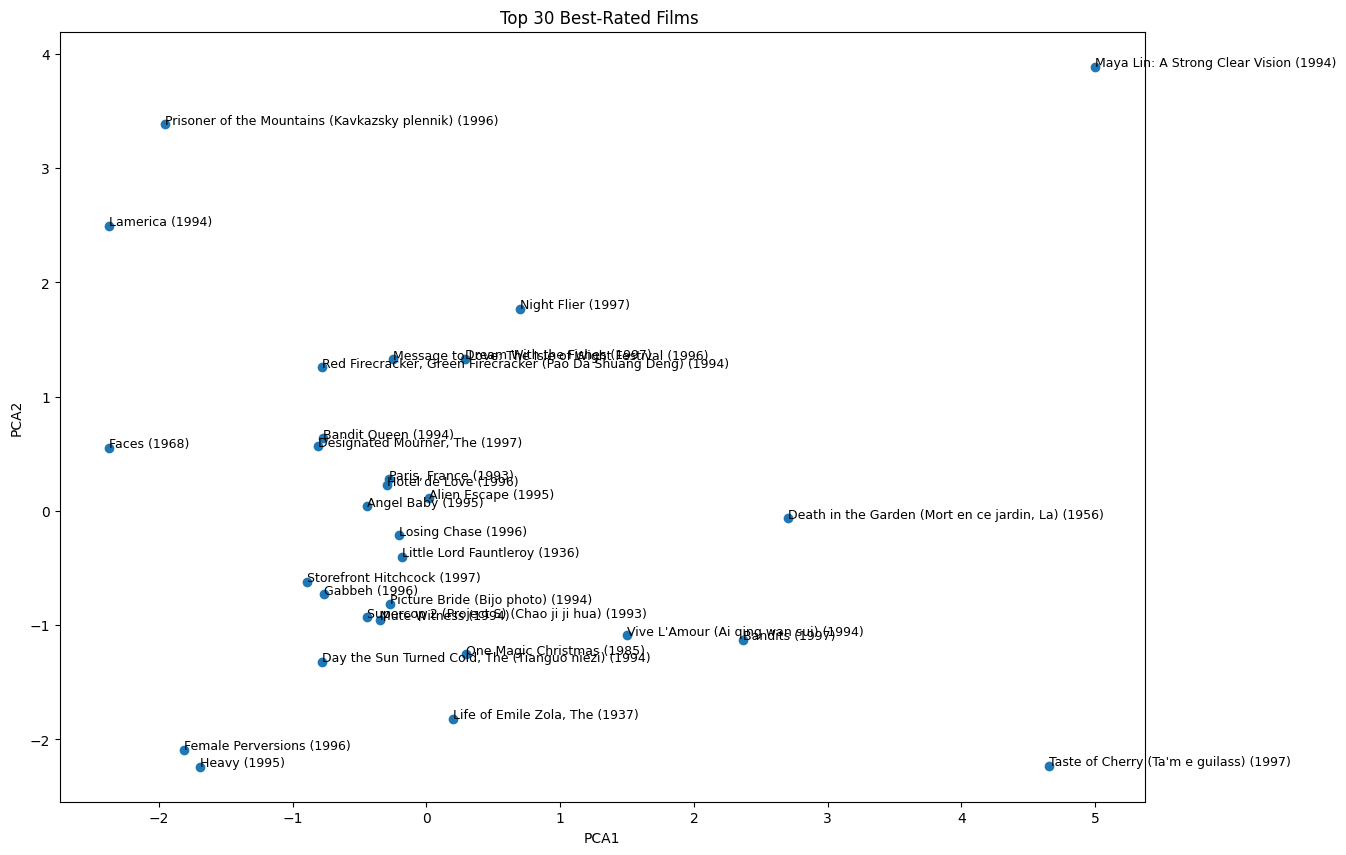

In [87]:
# Plot the 2D graph
plt.figure(figsize=(14, 10))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])
plt.title("Top 30 Best-Rated Films ")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
# Label each point with the movie title
for i, movie in top_rated_movies.iterrows():
    plt.annotate(movie['title'], (reduced_embeddings[i, 0], reduced_embeddings[i, 1]), fontsize=9)

plt.show()